# **Import Libraries**

In [101]:
 # Import Libraries
import numpy as np  # to handle matrix
import pandas as pd # to handle data
from matplotlib import pyplot as plt # to visualize
import datetime, pytz # to handle time
from sklearn.model_selection import train_test_split # Split data
from sklearn.ensemble import RandomForestRegressor # Random Forest Classifier
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
from torch.nn.functional import l1_loss
from sklearn.preprocessing import StandardScaler

## **Import The datasets Of yahoo finance**




In [102]:
# Define the ticker symbol for Bitcoin
ticker_symbol = 'BTC-USD'

# Fetch data from Yahoo Finance
btc_data = yf.download(ticker_symbol, start='2021-01-01', end='2024-01-01')

# print(btc_data)

# Display the first few rows
print(btc_data.head())

# Save the data to a CSV file
btc_data.to_csv('bitcoin_data.csv')

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344   
2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
2021-01-04  32810.949219  33440.218750  28722.755859  31971.914062   
2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688   

               Adj Close       Volume  
Date                                   
2021-01-01  29374.152344  40730301359  
2021-01-02  32127.267578  67865420765  
2021-01-03  32782.023438  78665235202  
2021-01-04  31971.914062  81163475344  
2021-01-05  33992.429688  67547324782  


## **Loading and Inspecting the Data**

In [103]:
import pandas as pd

# Load the data
btc_data = pd.read_csv('bitcoin_data.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows
print(btc_data.head())
print(btc_data.info())


                    Open          High           Low         Close  \
Date                                                                 
2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344   
2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
2021-01-04  32810.949219  33440.218750  28722.755859  31971.914062   
2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688   

               Adj Close       Volume  
Date                                   
2021-01-01  29374.152344  40730301359  
2021-01-02  32127.267578  67865420765  
2021-01-03  32782.023438  78665235202  
2021-01-04  31971.914062  81163475344  
2021-01-05  33992.429688  67547324782  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2021-01-01 to 2023-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1095 non-

# **Check Missing Values And Create Additional Features**

In [104]:
# Check for missing values
print(btc_data.isnull().sum())

# Fill missing values if any (forward fill method)
btc_data.fillna(method='ffill', inplace=True)

# Create additional features
btc_data['Open-Close'] = btc_data['Open'] - btc_data['Close']
btc_data['High-Low'] = btc_data['High'] - btc_data['Low']
btc_data['Volume-Change'] = btc_data['Volume'].pct_change()

# Drop rows with NaN values generated by pct_change
btc_data.dropna(inplace=True)

# Display the updated data
print(btc_data.head())



Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
                    Open          High           Low         Close  \
Date                                                                 
2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
2021-01-04  32810.949219  33440.218750  28722.755859  31971.914062   
2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688   
2021-01-06  34013.613281  36879.699219  33514.035156  36824.363281   

               Adj Close       Volume   Open-Close     High-Low  Volume-Change  
Date                                                                            
2021-01-02  32127.267578  67865420765 -2750.812500  4063.935547       0.666215  
2021-01-03  32782.023438  78665235202  -652.615234  2556.242188       0.159136  
2021-01-04  31971.914062  81163475344   839.035156  4717.462891       0.031758  
2

# **Features And Target**

In [105]:
# Define the features and target
features = ['Open-Close', 'High-Low', 'Volume-Change', 'Close']
target = 'Close'

# Create the input and output datasets
X = btc_data[features]
y = btc_data[target]

#Here x represents the features of any day and y reprsents the target(pedicting) value of the next day.

# Shift the target to predict the next day's price
y = y.shift(-1)
X = X[:-1]
y = y[:-1]


In [22]:
X


,Open-Close,High-Low,Volume-Change,Close
Date,,,,
2021-01-02,-2750.812500,4063.935547,0.666215,32127.267578
2021-01-03,-652.615234,2556.242188,0.159136,32782.023438
2021-01-04,839.035156,4717.462891,0.031758,31971.914062
2021-01-05,-2015.388672,4216.402344,-0.167762,33992.429688
2021-01-06,-2810.750000,3365.664062,0.114618,36824.363281
...,...,...,...,...
2023-12-26,1079.445312,1926.687500,0.422009,42520.402344
2023-12-27,-924.386719,1515.578125,-0.158722,43442.855469
2023-12-28,840.343750,1486.230469,-0.089816,42627.855469


from matplotlib import pyplot as plt
_df_0['Open-Close'].plot(kind='hist', bins=20, title='Open-Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['High-Low'].plot(kind='hist', bins=20, title='High-Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Volume-Change'].plot(kind='hist', bins=20, title='Volume-Change')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Open-Close', y='High-Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='High-Low', y='Volume-Change', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Volume-Change', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Open-Close'].plot(kind='line', figsize=(8, 4), title='Open-Close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['High-Low'].plot(kind='line', figsize=(8, 4), title='High-Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Volume-Change'].plot(kind='line', figsize=(8, 4), title='Volume-Change')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [23]:
y

Date
2021-01-02    32782.023438
2021-01-03    31971.914062
2021-01-04    33992.429688
2021-01-05    36824.363281
2021-01-06    39371.042969
                  ...     
2023-12-26    43442.855469
2023-12-27    42627.855469
2023-12-28    42099.402344
2023-12-29    42156.902344
2023-12-30    42265.187500
Name: Close, Length: 1093, dtype: float64

# **Split the data**
20% data is used as test data and othe 80% data used as training data in x and y

In [106]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


# **Train The Model**

In [107]:
from time import time

RF_NUM_TREES = 100
RF_MAX_DEPTH = 42

# Initialize the model
start_time = time()
rf = RandomForestRegressor(n_estimators=RF_NUM_TREES , random_state=RF_MAX_DEPTH)

# Train the model
rf.fit(X_train, y_train)
end_time = time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 0.395 seconds


# **Standarizeed the features**

In [95]:
# Standardize the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


In [96]:
X_test_scale

array([[0.40979554, 0.10386539, 0.27142787, 0.21877381, 0.22088146,
        0.23751392],
       [0.51361654, 0.06305443, 0.14471959, 0.22054405, 0.22343504,
        0.23095222],
       [0.49432511, 0.03088394, 0.11763162, 0.22172889, 0.22535917,
        0.23011144],
       ...,
       [0.54794821, 0.1113267 , 0.12354909, 0.55681898, 0.55402213,
        0.51836245],
       [0.52609063, 0.12804294, 0.15852598, 0.55646499, 0.55046014,
        0.50815662],
       [0.48706919, 0.07553013, 0.07690119, 0.55337166, 0.54776392,
        0.5092671 ]])

# **Make Predictions**

In [112]:
# Predict on the test set
y_pred = rf.predict(X_test)

# Display the first few predictions
print(y_pred[:5])

[26701.68300781 27089.69916016 28030.26783203 27998.37115234
 27830.46429688]


# **Plot the Variance**

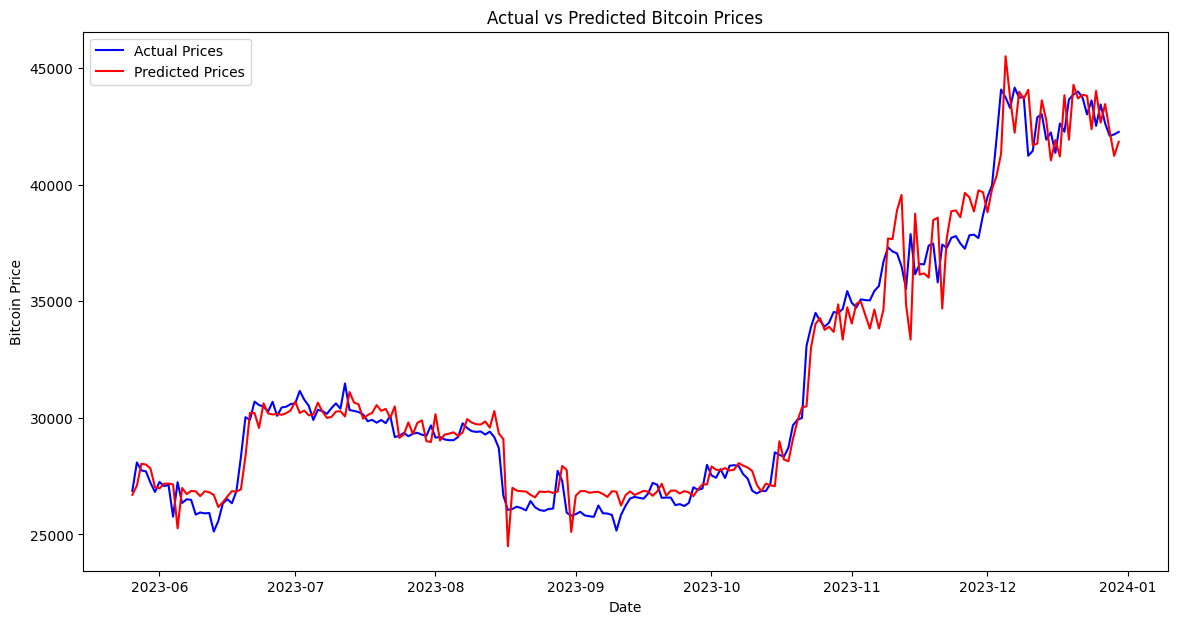

In [109]:
# Plot the actual vs predicted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Prices', color='b')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='r')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.legend()
plt.show()

# **Model Evaluation**

# **MAE**

In [116]:
import torch
from torch.nn.functional import l1_loss
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Convert predictions and true values to tensors
y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Calculate MAE using PyTorch
mae = l1_loss(y_pred_tensor, y_test_tensor, reduction='mean').item()
print(f"Mean Absolute Error (PyTorch): {mae}")







Mean Absolute Error (PyTorch): 722.8936157226562


# **Test Loss**

In [117]:
# Calculate MSE using PyTorch
mse_loss_fn = torch.nn.MSELoss()
test_loss = mse_loss_fn(y_pred_tensor, y_test_tensor).item()
print(f"Test Loss (MSE) (PyTorch): {test_loss}")


Test Loss (MSE) (PyTorch): 981973.9375


# **MSE**

In [118]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 981974.058645725


# **R-Squared**

In [119]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

R² Score: 0.9692663520875191


# **MAPE**

In [120]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Percentage Error (MAPE): 2.2542268487312787
